In [8]:
import numpy as np
import torch
from torch import normal
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.fft import fft2, fftshift
from torch import normal, tensor
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

## First implementation of AR Process (Recursive)

This is a translation of the quarter plane wold weights on to python

```r
psi_q <- function(i, j, phi_1, phi_2, phi_3) {
  if (i == 0 & j == 0) {
    return(1)
  }
  if (i == 0 & j > 0) {
    return(phi_1^j)
  }
  if (j == 0  & i > 0) {
    return(phi_3^i)
  }
  if (j == 1 & i == 1) {
    return(phi_1*phi_3*2 + phi_2)
  }
  return(phi_2 * Recall(i - 1, j - 1, phi_1, phi_2, phi_3)
        + phi_1 * Recall(i, j-1, phi_1, phi_2, phi_3)
        + phi_3 * Recall(i-1, j, phi_1, phi_2, phi_3))
}
```

In [ ]:
def psi_q(i, j, phi_1, phi_2, phi_3):
    if i == 0 and j == 0:
        return 1
    if i == 0 and j > 0:
        return phi_1**j
    if j == 0 and i > 0:
        return phi_3**i
    if j == 1 and i == 1:
        return 2*phi_1*phi_3 + phi_2
    
    return phi_2 * psi_q(i -1, j-1, phi_1, phi_2, phi_3) + \
            phi_1 * psi_q(i, j-1, phi_1, phi_2, phi_3) + \
            phi_3 * psi_q(i-1, j, phi_1, phi_2, phi_3)


In [21]:
psi_q(10, 10, .3, .3, .3)

0.03929334894403001

```r
wold_weights_quarter_plane <- function(N, M, phi_1, phi_2, phi_3) {
  f <- function(i, j) psi(i, j, phi_1, phi_2, phi_3)
  res <- matrix(0, N, M)
  for (i in 0:(N-1)) {
    for (j in 0:(M-1)) {
      res[i+ 1, M-j] <- psi_q(i, j, phi_1, phi_2, phi_3)
    }
  }
  return(res)
}
```

In [11]:
import numpy as np

def wold_w_q(N, M, phi_1, phi_2, phi_3):
    res = np.full((N,M), 0)
    for i in range(N):
        for j in range(M):
            res[i, M-j-1] = psi_q(i, j, phi_1, phi_2, phi_3)
    return res

## Making the implementation faster
We can make the implementation faster, by choosing what weights to construct in what order. This way you can use the recursive structure and scale the output in quadratic time and not in $\mathcal O(n!)$

We are also going to output a `pytorch` tensor to use this as a convolution later.

In [2]:
def wold_w_q_fast(N, phi_1, phi_2, phi_3):
    wold_weights = torch.full((N, N),0, dtype=torch.float32)
    wold_weights[:, N -1] = phi_3 **torch.arange(N)
    wold_weights[0, [i for i in reversed(range(N))]] = phi_1**torch.arange(N)

    phi = torch.tensor([phi_1, phi_2, phi_3]).reshape(1, 3)
    for i in range(1, N):
        for j in reversed(range(N-1)):
            wold_weights[i, j] = phi @ torch.tensor([wold_weights[i,j+1], wold_weights[i-1, j+1], wold_weights[i-1, j]]).reshape(3, 1)
    
    # position wold weights in the left corner

    res = torch.zeros((2*N -1, 2*N - 1))
    res[(N-1):(2*N-1), 0:N] = wold_weights
    return res

In [3]:
def wold_w_h_fast(N, phi_1, phi_2, phi_3, phi_4):
  phi = torch.tensor([phi_1, phi_2, phi_3, phi_4]).reshape(1,4)

  # diagonal and horizontal weights
  res = torch.full((2*N - 1, 2*N - 1),0, dtype=torch.float32)
  res[[i for i in range(N-1, 2*N-1)], [i for i in range(N-1, 2*N - 1)]] = phi_4 **torch.arange(N)
  res[N-1, [i for i in reversed(range(N))]] = phi_1**torch.arange(N)

  for i in range(N, 2*N-1):
    for j in reversed(range(0, i)):
      if i == 0:
        res = [i, j] = phi @ torch.tensor([res[i,j+1], res[i-1, j+1], res[i-1, j], 0]).reshape(4, 1)
      else:
        res[i, j] = phi @ torch.tensor([res[i,j+1], res[i-1, j+1], res[i-1, j], res[i-1, j-1]]).reshape(4, 1)
  return res

Based on these wold weights, we can now build a sampler, that uses the wold weights in a convolution

In [4]:
# now implementing the quarter plane sample
class PlaneSampler(torch.nn.Module):
  def __init__(self, wold_size, phi_1, phi_2, phi_3, phi_4 = 0):
    super().__init__()
    # constructing wold weights 
    K_buffer = wold_w_q_fast(wold_size, phi_1,  phi_2, phi_3) if phi_4 == 0 else wold_w_h_fast(wold_size, phi_1, phi_2, phi_3, phi_4)
    
    # register K in the buffer, such that it can be moved to a CUDA device
    self.register_buffer("K", K_buffer.reshape(1,1,*K_buffer.shape))
    self.padding = K_buffer.shape[0] // 2

  def forward(self, N, M, T = 1):
    N_tilde = N + 2 * self.padding
    M_tilde = M + 2 * self.padding
    eps = normal(0, 1, size = (T, N_tilde, M_tilde))
    eps = eps.reshape(T,1, N_tilde, M_tilde)
    return F.conv2d(eps, self.K)


## Testing the implementation

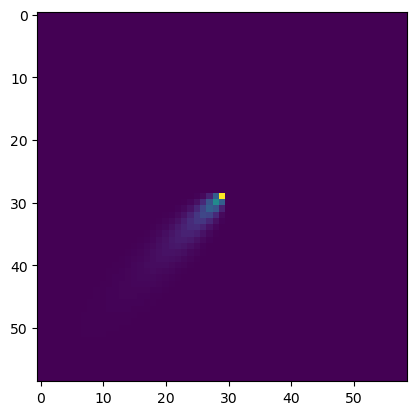

In [5]:
plt.imshow(wold_w_q_fast(30, .3, .3, .3))

In [135]:
wold_w_h_fast(5, .3, .3, .3, .3)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0081, 0.0270, 0.0900, 0.3000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0482, 0.1256, 0.2934, 0.5610, 0.4800, 0.3000, 0.0000, 0.0000, 0.0000],
        [0.1353, 0.2773, 0.4573, 0.5445, 0.4806, 0.2610, 0.0900, 0.0000, 0.0000],
        [0.2525, 0.4289, 0.5596, 0.5860, 0.4709, 0.2835, 0.1134, 0.0270, 0.0000],
        [0.3757, 0.5709, 0.6622, 0.6328, 0.4929, 0.3025, 0.1405, 0.0446, 0.0081]])

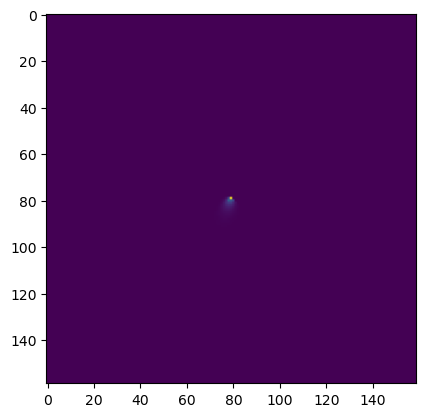

In [ ]:
plt.imshow(wold_w_h_fast(80, .2, .2, .2, .2))

In [9]:
def I(x):
  res = abs(fft2(x))**2 / (x.shape[0] * x.shape[1] * torch.var(x))
  return fftshift(res)

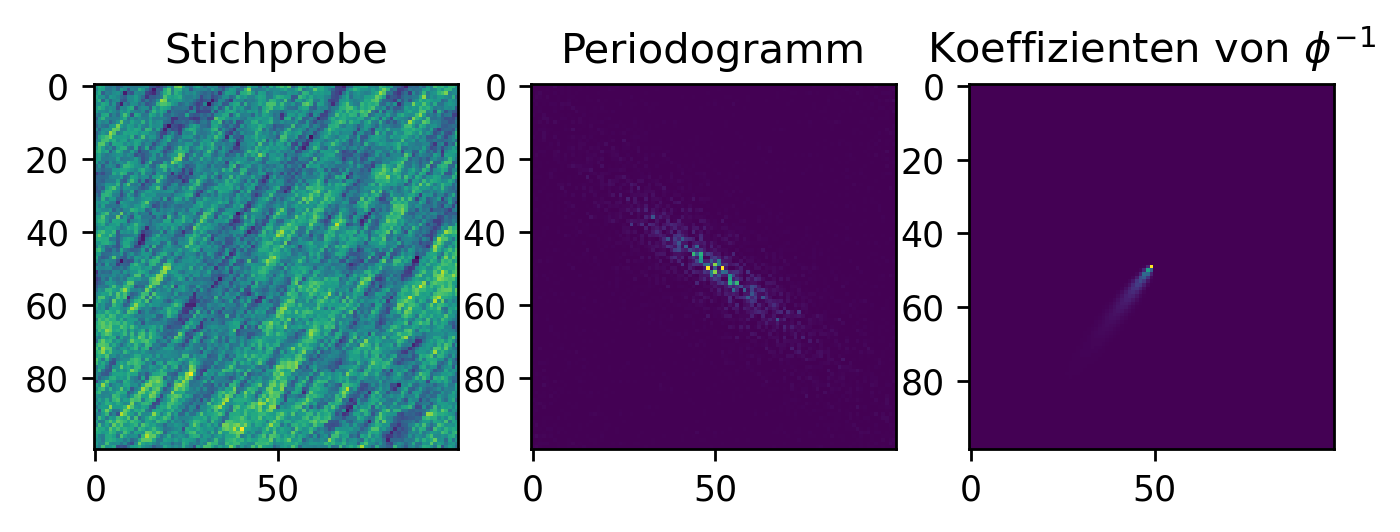

In [ ]:
# testing implementation
sampler = PlaneSampler(50, .1, .5, .3, 0)
x = sampler(100, 100)[0][0]
fig, (ax_1, ax_2, ax_3) = plt.subplots(1, 3)
fig.dpi = 250


ax_1.set_title("$100\times 100$ Pfad")
ax_1.imshow(x)

ax_2.imshow(I(x))
ax_2.set_title("Periodogramm")

ax_3.imshow(sampler.K[0][0])
ax_3.set_title(r"Koeffizienten von $\phi^{-1}$")
plt.show()

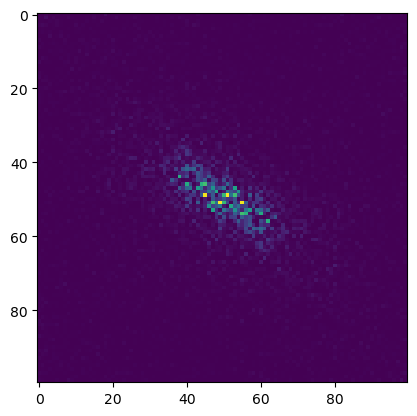

In [173]:
from source import I

plt.imshow(I(sampler(100, 100)[0][0]))